In [1]:
! pip install torchtext
! python -m spacy download en --quiet

⚠ As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use the
full pipeline package name 'en_core_web_sm' instead.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21.0, which is not installed.
explainable-ai-sdk 1.3.2 requires xai-image-widget, which is not installed.
tensorflow 2.6.2 requires numpy~=1.19.2, but you have numpy 1.20.3 which is incompatible.
tensorflow 2.6.2 requires six~=1.15.0, but you have six 1.16.0 which is incompatible.
tensorflow 2.6.2 requires typing-extensions~=3.7.4, but you have typing-extensions 3.10.0.2 which is incompatible.
tensorflow 2.6.2 requires wrapt~=1.12.1, but you have wrapt 1.13.3 which is incompatible.
tensorflow-transform 1.5.0 requires absl-py<0.13,>=0.9, but you have absl-py 0.15.0 which is incompatible.
tensorflow-transform 1.5.0 requires numpy<1.2

# Libraries

In [2]:
import re
import tqdm
import spacy
import torch
import random
import torch.nn as nn
import torch.optim as optim
import torchtext
import numpy as np
import pandas as pd
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from torchtext.legacy.data import Field, BucketIterator,TabularDataset
from tqdm import tqdm
from sklearn.metrics import accuracy_score
import nltk
from nltk.corpus import stopwords


In [3]:
STOPWORDS=stopwords.words('english')

# Parsing new dataset

In [4]:
def handle_apos(text):
    text = re.sub("'re", " are", text)
#     text = re.sub("'s", " is", text)
    text = re.sub("'m", " am", text)
    text = re.sub("'ll", " will", text)
    text = re.sub("'ve", " have", text)
    text = re.sub("'d", " would", text)
    text = re.sub("'t", " not", text)
    return text

def handle_punctuation(text):
    text = text.replace(".", " ")
    text = text.replace(",", " ")
    text = text.replace("!", " ")
    text = text.replace("?", " ")
    text = text.replace(";", " ")
    text = text.replace(":", " ")
    text = text.replace("-", " ")
    text = text.replace("(", " ")
    text = text.replace(")", " ")
    text = text.replace("[", " ")
    text = text.replace("]", " ")
    text = text.replace("{", " ")
    text = text.replace("}", " ")
    text = text.replace("/", " ")
    text = text.replace("\\", " ")
    text = text.replace("*", " ")
    text = text.replace("+", " ")
    text = text.replace("=", " ")
    text = text.replace("#", " ")
    text = text.replace("%", " ")
    text = text.replace("$", " ")
    text = text.replace("@", " ")
    text = text.replace("&", " ")
    text = text.replace("^", " ")
    text = text.replace("|", " ")
    text = text.replace("~", " ")
    text = text.replace("`", " ")
    text = text.replace("'", "")
    text = text.replace("\"", " ")
    text = text.replace("<", " ")
    text = text.replace(">", " ")
    text = text.replace("  ", " ")
    return text

In [5]:
def stop_words(text):
#     print(text)
    text=text.split()
    re=[]
    for x in text:
        if x not in STOPWORDS:
            re.append(x)
    return " ".join(re)

# Dataloaders

In [6]:
english=spacy.load('en_core_web_sm')

In [7]:
def en_tokenizer(text):
    tt = [token.text for token in english.tokenizer(text)]
    new_tt = []
    for i in range(len(tt)-2):
        new_tt.append(" ".join(tt[i:i+3]))
#     print(new_tt)
    return new_tt

def lb_tokenizer(text):
    return  [token.text for token in english.tokenizer(text)]


en_field = Field(tokenize=en_tokenizer,lower=True)
lb_field = Field(tokenize=lb_tokenizer,lower=True)

In [8]:
train_data=TabularDataset.splits(path="../input/domaintermextraction",train="data_sw.csv",format="csv",fields=[('content',en_field),('category',lb_field)],skip_header=True)[0]

In [9]:
batch_size=16
en_field.build_vocab(train_data,min_freq=2)
lb_field.build_vocab(train_data,specials_first=False)

In [10]:
len(en_field.vocab.itos)

49901

In [11]:
import pickle 
output_dict=pickle.load(open("../input/domaintermextraction/pandora.pkl","rb"))
unk_vect=output_dict["en_field"].vocab.vectors[output_dict["en_field"].vocab.stoi["<unk>"]]

In [12]:
glove_emmbed_dict = {}
glove_emmbed_dict["<unk>"]=unk_vect
glove_emmbed_dict["<pad>"]=np.zeros((200),dtype=float)

with open('../input/glove6b/glove.6B.200d.txt','r') as f:
    for line in tqdm(f):
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:],'float32')
        glove_emmbed_dict[word]=vector

400000it [00:23, 17249.26it/s]


In [13]:
def get_val(dic,val):
    if val in dic:
        return dic[val]
    else:
        return dic["<unk>"]

def n_gram(dic,embedd):
    re=[]
    for x in dic:
        x=x.split()
        temp=np.zeros((200),dtype=float)
        for y in x:
            temp+=np.array(get_val(embedd,y))
        re.append(temp/len(x))
    return np.array(re)

In [14]:
en_field.vocab.vectors=n_gram(en_field.vocab.stoi,glove_emmbed_dict)

In [15]:
en_field.vocab.vectors.shape

(49901, 200)

In [16]:
len(en_field.vocab.itos)

49901

In [17]:
train_iter,_,_ = BucketIterator.splits((train_data,train_data,train_data), batch_size = batch_size,sort_within_batch=True,sort_key=lambda x: len(x.content),device = device)

## save variables

In [18]:
en_field.vocab.vectors

array([[ 0.05530979,  0.00204107,  0.00948162, ...,  0.08513141,
         0.01224773, -0.00181833],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.47750332,  0.38942834,  0.29483032, ...,  0.09301513,
         0.11832   ,  0.32756333],
       ...,
       [ 0.14521001, -0.052892  , -0.252886  , ...,  0.03107067,
        -0.29974632,  0.18426666],
       [ 0.24343   ,  0.08431333, -0.70026668, ...,  0.21593001,
         0.21716666,  0.202321  ],
       [ 0.20437666, -0.12120001, -0.125613  , ..., -0.14796666,
        -0.02534833,  0.229463  ]])

In [19]:
! mkdir ./tri_gram

In [20]:
import pickle
output_dict={}
output_dict["en_field"]=en_field
output_dict["lb_field"]=lb_field
output_dict["embedding"]=en_field.vocab.vectors
pickle.dump(output_dict,open("./tri_gram/pandora_tri.pkl","wb"))

# Architecture

In [21]:
class LSTM_attention(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim_1, batch_size):
        super().__init__()
        self.weight = nn.Parameter(torch.zeros((batch_size,2*hidden_dim_1, 1)), requires_grad = True)
        self.embedding_layer = nn.Embedding(vocab_size, embedding_dim)
        self.embedding_layer.weight.data.copy_(torch.tensor(en_field.vocab.vectors))
        self.embedding_layer.weight.requires_grad = False ## freeze embeddings
        self.lstm_layer = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_dim_1, num_layers=5, batch_first=True, bidirectional=True)
        self.fc_layer1 = nn.Linear(2*hidden_dim_1, 5)    
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, input_sent):
        input_emb = self.embedding_layer(input_sent)
        sent_lstm_out,hid = self.lstm_layer(input_emb)
        M = torch.tanh(sent_lstm_out)
        mul = torch.matmul(M, self.weight)
        alpha = self.softmax(mul)
        r = torch.matmul(torch.transpose(sent_lstm_out, 1, 2), alpha)
        output = self.fc_layer1(r.reshape((r.shape[0], r.shape[1])))
        return output, alpha

In [22]:
lstm_model = LSTM_attention(en_field.vocab.vectors.shape[0], en_field.vocab.vectors.shape[1], 300, batch_size).double().cuda()
optimizer = optim.SGD(lstm_model.parameters(), lr=0.1)
loss_function = nn.CrossEntropyLoss()
num_epochs = 100
a = []
best_loss=float("inf")
best_accuracy=0
state={}
acc_arr=[]
loss_arr=[]
for epoch in range(num_epochs):
    current_loss = 0
    accuracy=0
    count=0
    for x in tqdm(train_iter):
        if x.content.T.shape[0] == 16:
            x_input = x.content.T.cuda()
            out, alpha = lstm_model(x_input)
            y_label =  x.category.T.reshape(x.category.T.shape[0]).cuda()
            accuracy_dash=accuracy_score(list(np.argmax(out.cpu().data.numpy(),axis=1)),list(y_label.cpu().data.numpy()))
            accuracy+=accuracy_dash
            count+=1
            loss = loss_function(out,y_label)
            current_loss += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    accuracy=accuracy/count
    current_loss=current_loss/count
    acc_arr.append(accuracy)
    loss_arr.append(current_loss)
    print("Epoch : ",epoch)
    print("Accuracy : ",accuracy)
    print("Loss : ",current_loss)
    if(best_accuracy<accuracy or accuracy>0.99):
        if accuracy - best_accuracy > 0.01 or accuracy > 0.95:
            torch.save(lstm_model,"./tri_gram/model_"+str(epoch)+"_"+str(accuracy)+"_"+str(current_loss)+".pt")
        best_accuracy=accuracy

100%|██████████| 102/102 [00:28<00:00,  3.56it/s]


Epoch :  0
Accuracy :  0.27784653465346537
Loss :  1.5928453083152356


100%|██████████| 102/102 [00:27<00:00,  3.71it/s]


Epoch :  1
Accuracy :  0.28279702970297027
Loss :  1.5886299613020263


  2%|▏         | 2/102 [00:01<00:57,  1.73it/s]


KeyboardInterrupt: 

In [23]:
print(lstm_model)

LSTM_attention(
  (embedding_layer): Embedding(49901, 200)
  (lstm_layer): LSTM(200, 300, num_layers=5, batch_first=True, bidirectional=True)
  (fc_layer1): Linear(in_features=600, out_features=5, bias=True)
  (softmax): Softmax(dim=1)
)


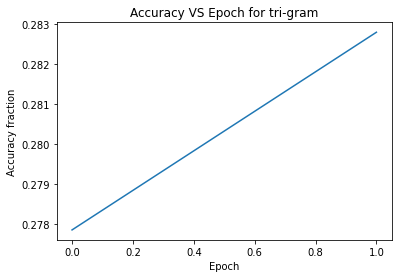

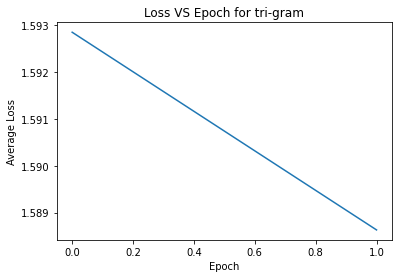

In [24]:
import matplotlib.pyplot as plt
plt.plot(acc_arr)
plt.title("Accuracy VS Epoch for tri-gram")
plt.xlabel("Epoch")
plt.ylabel("Accuracy fraction")
plt.show()
plt.plot(loss_arr)
plt.title("Loss VS Epoch for tri-gram")
plt.ylabel("Average Loss")
plt.xlabel("Epoch")
plt.show()

In [25]:
torch.save(lstm_model,"./tri_gram/final_model")

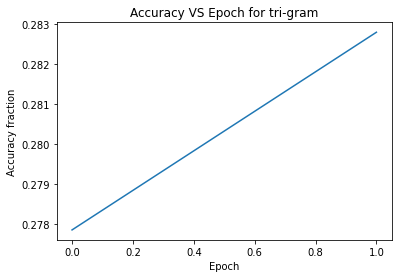

In [26]:
import matplotlib.pyplot as plt
plt.plot(acc_arr)
plt.title("Accuracy VS Epoch for tri-gram")
plt.xlabel("Epoch")
plt.ylabel("Accuracy fraction")
plt.savefig('./tri_gram/acc.jpg')

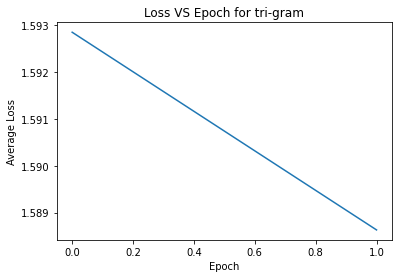

In [27]:
plt.plot(loss_arr)
plt.title("Loss VS Epoch for tri-gram")
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.savefig('./tri_gram/loss.jpg')

In [28]:
import shutil
shutil.make_archive("trigram", 'zip', "./tri_gram")

'/kaggle/working/trigram.zip'

In [29]:
import os
os.chdir(r'/kaggle/working/')
from IPython.display import FileLink
FileLink(r'./trigram.zip')

/kaggle/working/trigram.zip

In [31]:
key_word_scores = {}
r = 50
lstm_model.eval()
with torch.no_grad():
    for x in tqdm(train_iter):
        if x.content.T.shape[0] == 16:
            x_t = x.content.T
            label = np.array(x.category.T.cpu())
            label = label.reshape((label.shape[0]))
            out, alpha = lstm_model(x_t)
            alpha = alpha.cpu()
            for j in range(alpha.shape[0]):
                scores = []
                words = []
                ind = 0
                for k in range(alpha.shape[1]):
                    scores.append([alpha[j][k], en_field.vocab.itos[int(x_t[j][k])]])
                scores.sort(key=lambda y:y[0], reverse=True)
                while ind < alpha.shape[1]:
                    k = scores[ind]
                    if k[1] != "<pad>" and k[1] != "<unk>" and k[1] != " ":
                        words.append([k[1], k[0]])
                    ind += 1
                    if len(words) == r:
                        break
                if lb_field.vocab.itos[label[j]] not in key_word_scores.keys():
                    key_word_scores[lb_field.vocab.itos[label[j]]] = []
                key_word_scores[lb_field.vocab.itos[label[j]]].append(words)

 11%|█         | 11/102 [00:03<00:28,  3.15it/s]


KeyboardInterrupt: 

In [32]:
pickle.dump(key_word_scores, open("trigram_keywords.pkl","wb"))